<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Classification" data-toc-modified-id="Classification-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Classification</a></span><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Description</a></span></li></ul></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Filter-data" data-toc-modified-id="Filter-data-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Filter data</a></span></li><li><span><a href="#Knn" data-toc-modified-id="Knn-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Knn</a></span></li><li><span><a href="#Analysis-of-resulting-classifications" data-toc-modified-id="Analysis-of-resulting-classifications-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Analysis of resulting classifications</a></span></li><li><span><a href="#Evaluating-classification-techniques" data-toc-modified-id="Evaluating-classification-techniques-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Evaluating classification techniques</a></span></li></ul></li></ul></div>

# Classification

## Description

In [1]:
import feather
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import sparse

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MaxAbsScaler, scale
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from sklearn.decomposition import TruncatedSVD

# Progress bar
from ipywidgets import FloatProgress
from IPython.display import display

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Setup

In [2]:
#### Options #####
##################


begin_date       = '2017-06-30'
end_date         = begin_date

style_class      = 'lipper_class' # Choose lipper_class, style_class or cap_class
n_neighbors      = 15              # Number of neighbors to use in k-nn algorithm
perc_rows_used   = 2              # 1: all funds are reclassified once, 2: ... twice, etc.
distance_param   = 1              # 1: manhattan distance, 2: euclidian distance


## Load Data

In [3]:
### Returns
path = '../data/processed/returns.feather'
returns = feather.read_dataframe(path)
returns = returns.rename(columns = {'caldt' : 'report_dt'})

### row_info
path = '../data/processed/row_info.feather'
row_info = feather.read_dataframe(path)

### col_info
path = '../data/processed/col_info.feather'
col_info = feather.read_dataframe(path)

### Holdings
path = '../data/processed/holdings.npz'
holdings = sparse.load_npz(path)

## Filter data 

In [4]:
# Now filter everything
#######################
row_info_f = row_info.query('report_dt >= @begin_date and report_dt <= @end_date')
row_info_f = row_info_f.rename(columns={style_class : 'lipper'})

crsp_fundno_unique = row_info_f['crsp_fundno'].unique()
returns_f = returns.query('report_dt >= @begin_date and crsp_fundno in @crsp_fundno_unique')

holdings_f = holdings[row_info_f['row']]

col_sums = pd.DataFrame(holdings_f.sum(0).T).values 
mask = (col_sums != 0).flatten()
holdings_f = holdings_f[:,mask]

row_info_f.reset_index(drop = True, inplace=True)

print('Shape of row_info:')
print(row_info_f.shape)
print('Shape of holdings:')
print(holdings_f.shape)
print('Report_dt:')
print(row_info_f['report_dt'].describe())

Shape of row_info:
(2009, 8)
Shape of holdings:
(2009, 10481)
Report_dt:
count                    2009
unique                      1
top       2017-06-30 00:00:00
freq                     2009
first     2017-06-30 00:00:00
last      2017-06-30 00:00:00
Name: report_dt, dtype: object


## Knn 

In [5]:
X = holdings_f
y = list(row_info_f['lipper'].values)

mask = np.arange(X.shape[0])
y_df = pd.Series(y)

style_df = pd.DataFrame({
    'lipper' : y})

print('Dimensions match:       {}'.format(X.shape[0] == len(y)))

Dimensions match:       True


### Predicting based on full info

In [6]:
np.random.seed(0)

neigh_full = KNeighborsClassifier(
                        n_neighbors = n_neighbors,
                        p = distance_param,
                        n_jobs = -1)

neigh_full.fit(X,y) 

style_df.loc[:,'knn_full'] = neigh_full.predict(X)

### Predicting iteratively

In [7]:

#### Algo ####

np.random.seed(0)
n_rows = X.shape[0]
chosen_indices = []

# Setup of index for choosing rows iteratively
index = np.arange(n_rows)
np.random.shuffle(index)
index = np.concatenate((index,index,index,index,index))
n_rows_chosen = round(n_rows * perc_rows_used)
index = index[:n_rows_chosen]


# Setup
f = FloatProgress(min=0, max=n_rows_chosen)

style_df['knn_iterative'] = style_df['lipper']

# Loop over n_iterations, choose one observation randomly, predict label, save and repeat
print('Progress:')
display(f)

for k in np.arange(len(index)):
    # Choose random row based on rows and make mask
    i = index[k]
    chosen_indices.append(i)
    mask_temp = mask[mask != i]

    # Mask X and labels to exclude row for which prediction will be made
    X_temp = X[mask_temp]
    y_df_temp = style_df.loc[mask_temp,'knn_iterative'].values.tolist()

    # Fit knn model on all but randomly chosen row
    neigh = KNeighborsClassifier(n_neighbors = n_neighbors, p = distance_param, n_jobs = -1)
    neigh.fit(X_temp,y_df_temp) 

    # Predict and save label for randomly chosen row
    style_df.loc[i,'knn_iterative'] = neigh.predict(X[i])[0]

    f.value += 1

row_chosen = pd.Series(chosen_indices).unique().size
print('Rows randomly chosen:    {:4.2f}%'.format(row_chosen / X.shape[0] * 100))
print('Done')



Progress:


FloatProgress(value=0.0, max=4018.0)

Rows randomly chosen:    100.00%
Done


## Analysis of resulting classifications

### Distribution of classes per classification technique

Overlap between Lipper class and: 

Knn full prediction:         62.22%
Knn iterative prediction:    52.07%


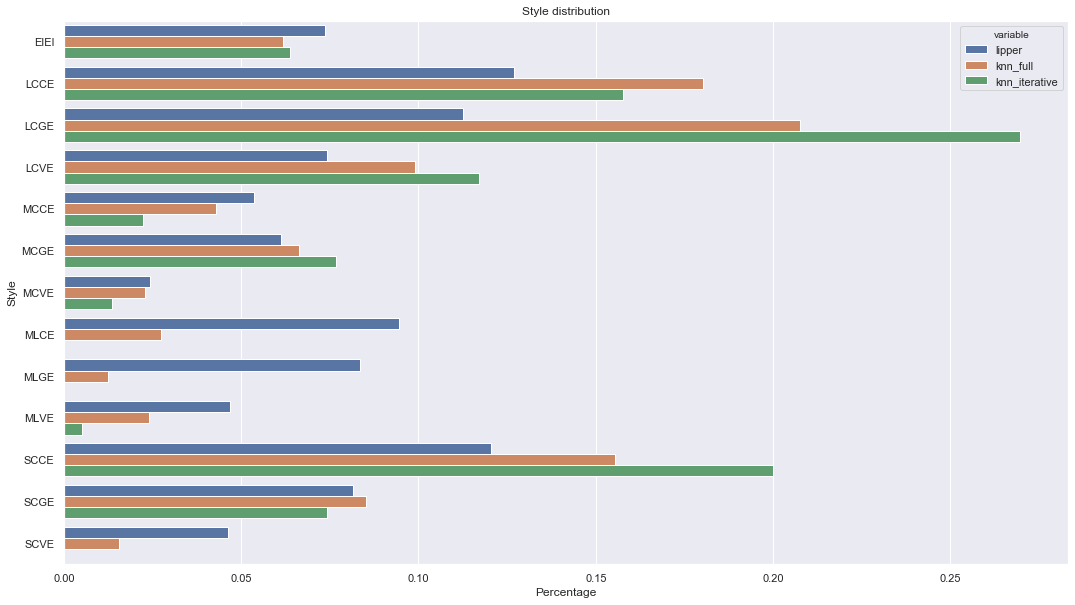

In [8]:
print('Overlap between Lipper class and: \n')
print('Knn full prediction:         {:2.2f}%'
      .format(np.sum(style_df['lipper'] == style_df['knn_full']) / len(style_df.index) * 100))
print('Knn iterative prediction:    {:2.2f}%'
      .format(np.sum(style_df['lipper'] == style_df['knn_iterative']) / len(style_df.index) * 100))

data = style_df.apply(pd.Series.value_counts, normalize = True)
data = data.assign(style = data.index)
data = data.melt(id_vars = 'style', value_vars = data.columns[:-1])

sns.set()
plt.figure(figsize=(18,10))
g = sns.barplot(data = data, y = 'style', x = 'value', hue = 'variable')

plt.title('Style distribution')
plt.ylabel('Style')
plt.xlabel('Percentage')

plt.show()

### Transition tables

In [9]:
round(pd.crosstab(style_df['lipper'], style_df['knn_iterative'], margins=True, normalize='all') * 100,2)

knn_iterative,EIEI,LCCE,LCGE,LCVE,MCCE,MCGE,MCVE,MLVE,SCCE,SCGE,All
lipper,,,,,,,,,,,
EIEI,3.58,1.54,0.45,1.44,0.00,0.00,0.05,0.00,0.30,0.00,7.37
LCCE,0.70,7.86,3.33,0.75,0.00,0.00,0.00,0.00,0.05,0.00,12.69
LCGE,0.00,0.40,10.80,0.05,0.00,0.00,0.00,0.00,0.00,0.00,11.25
LCVE,1.00,0.80,0.10,5.43,0.00,0.00,0.00,0.05,0.05,0.00,7.42
MCCE,0.25,0.05,0.65,0.10,1.10,0.95,0.55,0.00,1.69,0.05,5.38
MCGE,0.00,0.10,0.45,0.05,0.00,4.93,0.05,0.00,0.10,0.45,6.12
MCVE,0.15,0.05,0.25,0.25,0.70,0.00,0.50,0.05,0.50,0.00,2.44
MLCE,0.60,3.98,3.38,0.40,0.35,0.05,0.05,0.10,0.55,0.00,9.46
MLGE,0.00,0.35,6.67,0.05,0.00,1.29,0.00,0.00,0.00,0.00,8.36


### Comparing mean return per class for the different classification techniques

In [10]:
row_info_f = row_info_f.assign(
    knn_full = style_df['knn_full'],
    knn_iterative = style_df['knn_iterative']
)

cols = ['lipper','knn_full','knn_iterative']

returns_f_merged = returns_f.merge(row_info_f[['crsp_fundno','report_dt','lipper','knn_full','knn_iterative']]
              ,how='left',on=['crsp_fundno','report_dt'])

returns_f_merged[cols] = (returns_f_merged
                         .groupby('crsp_fundno')
                         .apply(
                             lambda x: x[cols]
                             .fillna(method='ffill')))
returns_f_merged = returns_f_merged.dropna()

def cum_ret_per_class(returns,cols):
    return_temp = returns
    
    for i, col in enumerate(cols):
        temp = (return_temp
                    .rename(columns= {col : 'style'})
                    .assign(cumret = lambda df: df['mret'] + 1)
                    .groupby(['style','report_dt'])
                    .mean()
                    .reset_index()
                    .assign(model = 'full')
                    .set_index(['style','report_dt'])
                    .groupby(['style'])
                    .cumprod()
                    .reset_index()
                    .assign(model = col))
        
        if (i == 0):
            return_df = temp
        else:
            return_df = pd.concat([return_df,temp],sort=False)
        
    return_df = return_df[['model','style','report_dt','cumret']]
    return return_df
    

style_cumreturn = cum_ret_per_class(returns_f_merged,cols)

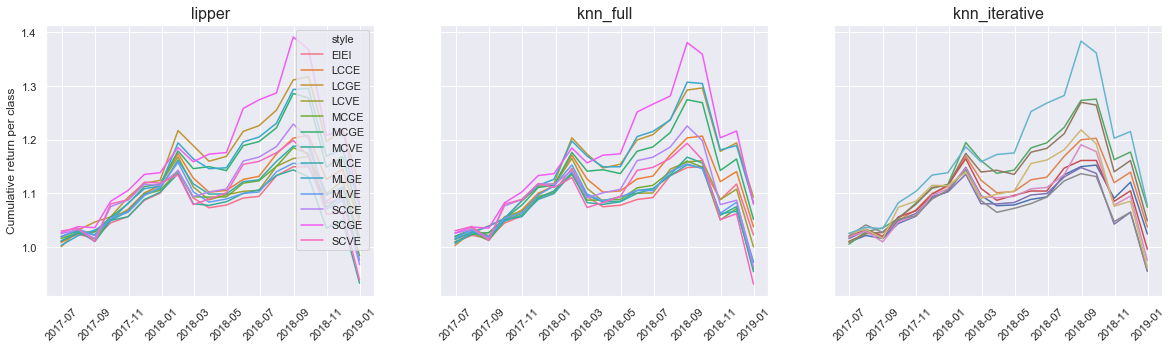

In [11]:
fig, ax = plt.subplots(figsize=(20,5),ncols=3, sharey='row')
for i, col in enumerate(cols):
    sns.lineplot(data = style_cumreturn.query(''' model == @col '''), x='report_dt', y='cumret', hue='style', ax=ax[i])

# Subplot titles
title = cols
ax[0].set_ylabel('Cumulative return per class')

for i in range(0,3):
    ax[i].set_title(title[i], fontsize = 16)
    ax[i].set_xlabel('')
    for label in ax[i].get_xticklabels():
        label.set_rotation(45)
        
for i in range(1,3):
    ax[i].get_legend().remove()

plt.show()

## Evaluating classification techniques

### MSE between each fund and average style return

In [12]:
def mean_ret_per_class(returns,cols):
    return_temp = returns
    
    for i, col in enumerate(cols):
        temp = (return_temp
                    .rename(columns= {col : 'style'})
                    .groupby(['style','report_dt'])
                    .mean()
                    .reset_index()
                    .assign(model = 'full')
                    .drop(columns=['crsp_fundno'])
                    .assign(model = col))
        
        if (i == 0):
            return_df = temp
        else:
            return_df = pd.concat([return_df,temp],sort=False)
        
    return_df = return_df[['model','style','report_dt','mret']]
    return(return_df)

In [13]:
def calc_mse(returns,style_return):
    
    models = style_return['model'].unique()
    
    return_df = pd.DataFrame(columns=['model','mse'])
    
    for i,model in enumerate(models):
        temp_df = (returns
                .rename(columns={'mret' : 'fund_ret'})
                .merge(style_return.query('model == @model'),
                    how ='left',
                    left_on = [model,'report_dt'],
                    right_on = ['style','report_dt'])
                .drop(columns = cols)
                .assign(error = lambda df: df['mret'] - df['fund_ret']))
        
        return_df.loc[i,'model'] = model
        return_df.loc[i,'mse'] = mean_squared_error(temp_df['mret'],temp_df['fund_ret'])

    return(return_df)

In [14]:
style_mean_return = mean_ret_per_class(returns_f_merged,cols)
calc_mse(returns_f_merged,style_mean_return)

,model,mse
0,lipper,0.000225165
1,knn_full,0.000232801
2,knn_iterative,0.000248235


### Analysing individual portfolios

In [15]:
comparing_df.query('''true == 'V' and iterative_5 == 'G' ''').head()

NameError: name 'comparing_df' is not defined

In [ ]:
no = 69
crsp_fundno = row_info.reset_index().loc[no].crsp_fundno

most_common_stocks_fund(year=2017, crsp_fundno=crsp_fundno)

In [ ]:
def most_common_stocks_fund(year,crsp_fundno):
    "This prints a passed string into this function"
    # Enter date for which most common holdings are calculated
    year = year
    crsp_fundno = crsp_fundno
    row_info_l = row_info.copy()

    holdings_coo = holdings.tocoo()

    df_sparse = pd.DataFrame({'row'  : holdings_coo.row,
                              'col'  : holdings_coo.col,
                              'data' : holdings_coo.data})

    row_info_l = row_info_l.assign(year = row_info_l['report_dt'].dt.year)
    df_sparse = df_sparse.merge(row_info_l[['year','row','crsp_fundno']],how='left',on='row')
    my_filter = '''year == @year and crsp_fundno == @crsp_fundno '''
    no_unique_funds = row_info_l.query(my_filter).shape[0]

    sum_col = (df_sparse
               .query(my_filter)
               .groupby(by = ['col'])
               .mean()
               .sort_values('data',ascending = False)
               .join(col_info[['security_name','col']],how='left')
               .assign(percent = lambda x:  x.data)
               .drop(columns=['row','data','col','year','crsp_fundno'])
               .reset_index(drop=True)
               .head(10))
    
    print(
        'Average of most held stocks for one fund in one year: ','\n\n'
        '{}'.format(row_info.query('crsp_fundno == @crsp_fundno').iloc[0,2]),'\n\n'
        'crsp_fundno:                            {}'.format(crsp_fundno),'\n'
        'Year:                                   {}'.format(year),'\n'
        'Number of observations in that year:    {}'.format(no_unique_funds))

    return sum_col